In [72]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
import itertools
import powerlaw
import math
import warnings
import pygraphviz as PG
from IPython import display
warnings.filterwarnings('ignore')

## Find largest and second largest flow
Largest flow based on out-strength

In [59]:
def find_largest_1_2(grafo):
    largest_1 = []
    largest_2 = []
    for i in grafo.nodes:
        #largest=0
        out_strength = list(grafo.out_edges(i, data='weight'))
        sort_out_strength = sorted(out_strength,key=lambda item: item[2], reverse=True)
        
        # Level 1
        if(len(sort_out_strength) > 0):
            largest_1.append(sort_out_strength[0])
            
        # Level 2
        if(len(sort_out_strength) > 1):
            largest_2.append(sort_out_strength[1])
    
    return largest_1, largest_2


## Create graphs

In [60]:
def create_graphs(grafo, largest_1, largest_2):
    grafo_1 = nx.DiGraph()
    grafo_1.add_nodes_from(grafo.nodes)
    grafo_1.add_weighted_edges_from(largest_1)

    grafo_2 = nx.DiGraph()
    grafo_2.add_nodes_from(grafo.nodes)
    grafo_2.add_weighted_edges_from(largest_2)
    
    return grafo_1, grafo_2

## Draw graphs

In [61]:
def draw_graphs(grafo_1, grafo_2):
    options = {
        'node_color': '#87E5DF',
        'node_size': 300,
        'width': 1,
        'with_labels':True
    }

    plt.figure(3,figsize=(17,8)) 
    subax1 = plt.subplot(121)
    nx.draw_shell(grafo_1, **options)
    subax2 = plt.subplot(122)
    nx.draw_shell(grafo_2, **options)

## Find dominants and subdominants
Measure of size is determined by the total in-strength

In [62]:
def sort_measure_size(in_strength):
    #in_strength = list(in_degree_grafo)
    sort_in_strength = sorted(in_strength,key=lambda item: item[1],
                              reverse=True)
    return sort_in_strength

In [63]:
def find_possible_dominants(in_degree_grafo, grafo_1):

    dic_dominants = {}

    for i in grafo_1.edges:
        # Find their in-strenth values to determine which is bigger
        # We are evaluating the dominance of i[0] (tail)
        str_tail = in_degree_grafo[i[0]]
        str_head = in_degree_grafo[i[1]]

        if( (str_tail > str_head) ):
            # Tail is bigger than head, then tail could be a dominant
            if not(i[0] in dic_dominants.keys()):
                dic_dominants[i[0]]=0
        else:
            # Increase the number of smaller cities which has their 
            # largest flow into the place i[1]
            if i[1] in dic_dominants.keys():
                dic_dominants[i[1]]+=1
            else:
                dic_dominants[i[1]]=1
                
    return dic_dominants

In [64]:
def find_dominants(in_degree_grafo, grafo_1, porcentaje, sort_in_strength):
    
    dic_dominants = find_possible_dominants(in_degree_grafo, grafo_1)
    
    dominants = []
    index = 0
    
    for i in sort_in_strength:
        index += 1
        
        if (i[0] in dic_dominants.keys()):
            num_small_cities = len(sort_in_strength[index:])
            if (num_small_cities>0):
                if (dic_dominants[i[0]] / num_small_cities >= porcentaje ):
                    dominants.append(i[0])

    return dominants

In [65]:
def find_possible_subdominants(dominants, in_degree_grafo, grafo_1, grafo_2):
    dic_subdominants = {}
    dic_predecessor = {}

    # Traverse largest flow
    for i in grafo_1.edges():

        # Verify if its largest flow flows to a dominant city and origin is not a dominant
        if (i[1] in dominants) & (not(i[0] in dominants)):
            dic_subdominants[i[0]]=0
            #print("H: ", i[0], i[1])
            
            #if not(i[0] in dic_predecessor.keys()):
            #    dic_predecessor[i[0]]=[]
                
            # Each subdominant only has one predecessor at most
            dic_predecessor[i[0]]=i[1]
            
    
    # Traverse second largest flow
    for i in grafo_2.edges():
        str_tail = in_degree_grafo[i[0]]
        str_head = in_degree_grafo[i[1]]
        #print(str_tail, str_head)
        
        if( (str_tail < str_head) ):
            # Increase the number of smaller cities which has their second largest flow into the place i[1]
            if i[1] in dic_subdominants.keys():
                dic_subdominants[i[1]]+=1
                
    return dic_subdominants, dic_predecessor    

In [66]:
def find_subdominants(dominants, in_degree_grafo,grafo_1, grafo_2, porcentaje, sort_in_strength):
    dic_subdominants, dic_predecessor = find_possible_subdominants(dominants, in_degree_grafo,
                                                  grafo_1, grafo_2)
    subdominants = []
    index = 0
    for i in sort_in_strength:
        index += 1

        if (i[0] in dic_subdominants.keys()):
            num_small_cities = len(sort_in_strength[index:])
            
            if (num_small_cities>0): #and (not (i[0] in subdominants))
                if (dic_subdominants[i[0]] / num_small_cities >= porcentaje):
                    subdominants.append(i[0])
    return subdominants, dic_predecessor

In [106]:
def Update_data(grafo, dominants, in_degree_grafo_l):
    
    grafo.remove_nodes_from(dominants)

    in_degree_grafo_l2 = [i for i in in_degree_grafo_l if not(i[0] in dominants)] 

    sort_in_strength = sort_measure_size(in_degree_grafo_l2)
    return grafo, sort_in_strength, in_degree_grafo_l2

In [112]:
def dominant_flow(grafo, porcDom, porSubDom, porIni, porDiv, uDotWalk, uImgWalk):
    
    # Measure of size is a global metric, it doesn't change
    in_degree_grafo_d = dict(grafo.in_degree(weight='weight')) # Dictionary
    in_degree_grafo_l = list(grafo.in_degree(weight='weight')) # List

    # Measure of size ordered, it will change when the dominants are removed
    sort_in_strength = sort_measure_size(in_degree_grafo_l) 

    # Initialize tree
    turisG = PG.AGraph(directed=True, strict=True)
    
    largest_1, largest_2 = find_largest_1_2(grafo)
    grafo_1, grafo_2 = create_graphs(grafo, largest_1, largest_2)
    #draw_graphs(grafo_1, grafo_2)

    # Find dominants
    dominants = find_dominants(in_degree_grafo_d, grafo_1, porcDom, sort_in_strength)
    subdominant, dic_predecessor = find_subdominants(dominants, in_degree_grafo_d, grafo_1, grafo_2, porSubDom,sort_in_strength)

    #print(dominants)
    for i in subdominant:
        turisG.add_edge(i, dic_predecessor[i])
        
    n = porIni
    while len(subdominant)!=0:
        grafo, sort_in_strength, in_degree_grafo_l = Update_data(grafo, dominants, in_degree_grafo_l)

        #print(sort_in_strength)
        largest_1, largest_2 = find_largest_1_2(grafo)

        grafo_1, grafo_2 = create_graphs(grafo, largest_1, largest_2)
        #draw_graphs(grafo_1, grafo_2)

        dominants = subdominant

        n = n/porDiv
        subdominant, dic_predecessor = find_subdominants(dominants, in_degree_grafo_d, grafo_1, grafo_2, 
                                                           n,sort_in_strength)

        for i in subdominant:
            turisG.add_edge(i, dic_predecessor[i])
        #print("\n")
        
    # save the graph in dot format
    turisG.write(uDotWalk)

    # pygraphviz renders graphs in neato by default, 
    # so you need to specify dot as the layout engine
    turisG.layout(prog='dot')

    turisG.draw(uImgWalk)

## Read graph

### Departamentos

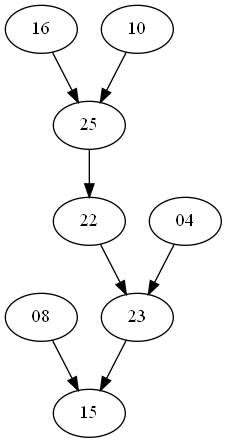

In [113]:
uGraph = "Input/grafoPeruDepartamentos.net"
uImgWalk="Figuras/corredorDistrital_DF.png"
uDotWalk="Output/corredorDistrital_DF.dot"

grafo = nx.DiGraph(nx.read_pajek(uGraph))
dominant_flow(grafo,0.1, 0.15, 0.01, 1, uDotWalk, uImgWalk)
display.Image(uImgWalk)

### Provincias

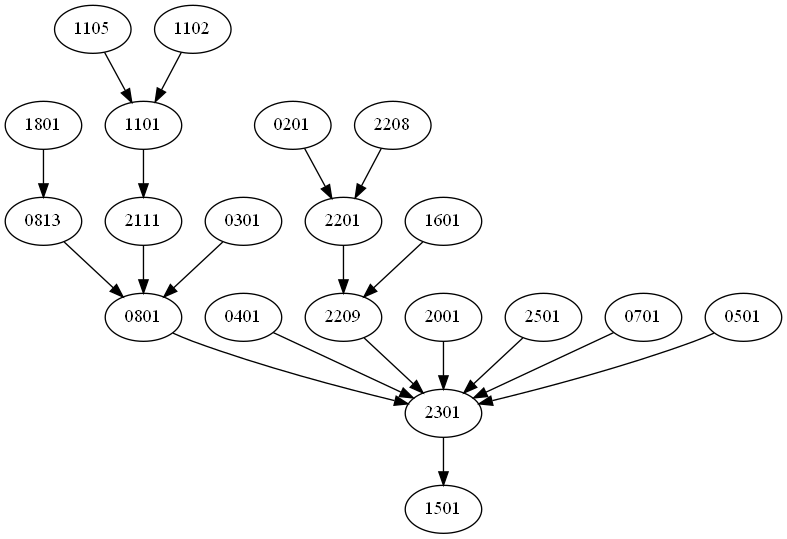

In [114]:
uGraph = "Input/grafoPeruProvincias.net"
uImgWalk="Figuras/corredorProvincial_DF.png"
uDotWalk="Output/corredorProvincial_DF.dot"

grafo = nx.DiGraph(nx.read_pajek(uGraph))
dominant_flow(grafo,0.1, 0.1, 0.01, 1, uDotWalk, uImgWalk)
display.Image(uImgWalk)

### Distritos

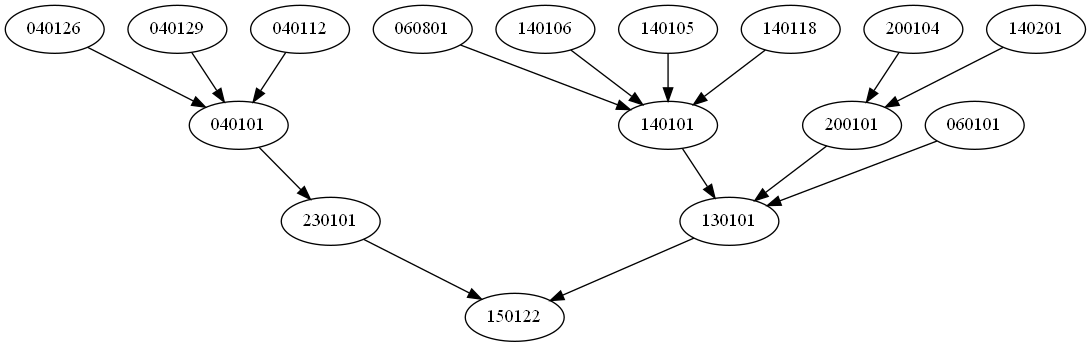

In [115]:
uGraph = "Input/grafoPeruDistritos.net"
uImgWalk="Figuras/corredorDistrital_DF.png"
uDotWalk="Output/corredorDistrital_DF.dot"

grafo = nx.DiGraph(nx.read_pajek(uGraph))
dominant_flow(grafo,0.1, 0.05, 0.1, 10, uDotWalk, uImgWalk)
display.Image(uImgWalk)

---------------------------------------------------------------------------------------

## Dep Antiguo

In [73]:
grafo = nx.DiGraph(nx.read_pajek("Input/grafoPeruDepartamentos.net"))

# Measure of size is a global metric, it doesn't change
in_degree_grafo_d = dict(grafo.in_degree(weight='weight')) # Dictionary
in_degree_grafo_l = list(grafo.in_degree(weight='weight')) # List

# Measure of size ordered, it will change when the dominants are removed
sort_in_strength = sort_measure_size(in_degree_grafo_l) 

# Initialize tree
turisG = PG.AGraph(directed=True, strict=True)

largest_1, largest_2 = find_largest_1_2(grafo)
grafo_1, grafo_2 = create_graphs(grafo, largest_1, largest_2)
#draw_graphs(grafo_1, grafo_2)

# Find dominants
dominants = find_dominants(in_degree_grafo_d, grafo_1, 0.1, sort_in_strength)
subdominant, dic_predecessor = find_subdominants(dominants, in_degree_grafo_d, grafo_1, grafo_2, 0.15,sort_in_strength)

print(dominants)
for i in subdominant:
    turisG.add_edge(i, dic_predecessor[i])
    
n = 0.01
while len(subdominant)!=0:
    grafo, sort_in_strength, in_degree_grafo_l = Update_data(grafo, dominants, in_degree_grafo_l)

    #print(sort_in_strength)
    largest_1, largest_2 = find_largest_1_2(grafo)

    grafo_1, grafo_2 = create_graphs(grafo, largest_1, largest_2)
    #draw_graphs(grafo_1, grafo_2)

    dominants = subdominant
    
    #n = n/10
    subdominant, dic_predecessor = find_subdominants(dominants, in_degree_grafo_d, grafo_1, grafo_2, 
                                                       n,sort_in_strength)
    
    for i in subdominant:
        turisG.add_edge(i, dic_predecessor[i])
    #print("\n")
    
# save the graph in dot format
turisG.write('Output/corredorDepartamental.dot')

# pygraphviz renders graphs in neato by default, 
# so you need to specify dot as the layout engine
turisG.layout(prog='dot')

turisG.draw("Figuras/corredorDepartamental.png")

display.Image("Figuras/corredorDepartamental.png")

## Prov Antiguo

In [ ]:
grafo = nx.DiGraph(nx.read_pajek("Input/grafoPeruProvincias.net"))

# Measure of size is a global metric, it doesn't change
in_degree_grafo_d = dict(grafo.in_degree(weight='weight')) # Dictionary
in_degree_grafo_l = list(grafo.in_degree(weight='weight')) # List

# Measure of size ordered, it will change when the dominants are removed
sort_in_strength = sort_measure_size(in_degree_grafo_l)     

# Initialize tree
turisG = PG.AGraph(directed=True, strict=True)

largest_1, largest_2 = find_largest_1_2(grafo)
grafo_1, grafo_2 = create_graphs(grafo, largest_1, largest_2)
#draw_graphs(grafo_1, grafo_2)

# Find dominants
dominants = find_dominants(in_degree_grafo_d, grafo_1, 0.1, sort_in_strength)
subdominant, dic_predecessor = find_subdominants(dominants, in_degree_grafo_d, grafo_1, grafo_2, 0.1,sort_in_strength)

print(dominants)
# Add relation between dominants and subdominants
for i in subdominant:
    turisG.add_edge(i, dic_predecessor[i])

n = 0.01
while len(subdominant)!=0:
    grafo, sort_in_strength, in_degree_grafo_l = Update_data(grafo, dominants, in_degree_grafo_l)

    #print(sort_in_strength)
    largest_1, largest_2 = find_largest_1_2(grafo)

    grafo_1, grafo_2 = create_graphs(grafo, largest_1, largest_2)
    #draw_graphs(grafo_1, grafo_2)

    
    dominants = subdominant
    
    #n = n/10
    subdominant, dic_predecessor = find_subdominants(dominants, in_degree_grafo_d, grafo_1, grafo_2, 
                                                       n,sort_in_strength)
    
    for i in subdominant:
        turisG.add_edge(i, dic_predecessor[i])
        #print(i, dic_predecessor[i])
    #print("\n")
    
# save the graph in dot format
turisG.write('Output/corredorProvincial.dot')
turisG.layout(prog='dot')

turisG.draw("Figuras/corredorProvincial.png")
display.Image("Figuras/corredorProvincial.png")

## Dis Antiguo

In [104]:
grafo = nx.DiGraph(nx.read_pajek("Input/grafoPeruDistritos.net"))

# Measure of size is a global metric, it doesn't change
in_degree_grafo_d = dict(grafo.in_degree(weight='weight')) # Dictionary
in_degree_grafo_l = list(grafo.in_degree(weight='weight')) # List

# Measure of size ordered, it will change when the dominants are removed
sort_in_strength = sort_measure_size(in_degree_grafo_l)     

# Initialize tree
turisG = PG.AGraph(directed=True, strict=True)

largest_1, largest_2 = find_largest_1_2(grafo)
grafo_1, grafo_2 = create_graphs(grafo, largest_1, largest_2)
#draw_graphs(grafo_1, grafo_2)

# Find dominants
dominants = find_dominants(in_degree_grafo_d, grafo_1, 0.1, sort_in_strength)
subdominant, dic_predecessor = find_subdominants(dominants, in_degree_grafo_d, grafo_1, grafo_2, 0.05,sort_in_strength)

print(dominants)
for i in subdominant:
    turisG.add_edge(i, dic_predecessor[i])
    
n = 0.1
while len(subdominant)!=0:
    grafo, sort_in_strength, in_degree_grafo_l = Update_data(grafo, dominants, in_degree_grafo_l)

    #print(sort_in_strength)
    largest_1, largest_2 = find_largest_1_2(grafo)

    grafo_1, grafo_2 = create_graphs(grafo, largest_1, largest_2)
    #draw_graphs(grafo_1, grafo_2)

    
    dominants = subdominant
    
    n = n/10
    subdominant, dic_predecessor = find_subdominants(dominants, in_degree_grafo_d, grafo_1, grafo_2, 
                                                       n,sort_in_strength)
    
    for i in subdominant:
        turisG.add_edge(i, dic_predecessor[i])
        #print(i, dic_predecessor[i])
    #print("\n")
    
# save the graph in dot format
turisG.write('Output/corredorDistrital.dot')
turisG.layout(prog='dot')

turisG.draw("Figuras/corredorDistrital.png")
display.Image("Figuras/corredorDistrital.png")